### Результаты определения угла поворота MNIST

In [2]:
import glob
import os
import pickle
import json
import numpy as np

In [3]:
from collections import defaultdict

In [4]:
from matplotlib import pyplot as plt
import matplotlib
matplotlib.rcParams.update({
    'font.size': 14
})

Варьировались два параметра: угол $\alpha_0$  и `dataset_size`. Число шагов фиксировано: 50. Число стартовых точек 10. Сеть имеет следующую структуру:

In [5]:
from keras.models import model_from_json
with open('model_architecture.json', 'r') as iofile:
    model_architecture = json.load(iofile)    
model = model_from_json(model_architecture)
model.summary()

Using TensorFlow backend.
/home/nexes/miniconda3/envs/tf_py3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 128)               100480    
_________________________________________________________________
dropout_3 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 128)               16512     
_________________________________________________________________
dropout_4 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 2)                 258       
Total params: 117,250
Trainable params: 117,250
Non-trainable params: 0
_________________________________________________________________


In [7]:
all_results_dict = defaultdict(dict)
for start_idx in [4,5,6]:
    for filename in glob.glob('parallel_BO_results/start{}/*_start.pcl'.format(start_idx)):
        alpha, data_size = os.path.splitext(os.path.basename(filename))[0].split('_')[:2]
        alpha = float(alpha)
        data_size = int(data_size)
        with open(filename, 'rb') as iofile:
            all_results_dict[start_idx-4][(alpha, data_size)] = pickle.load(iofile)

In [11]:
angle_to_idx = {
    angle: idx for idx, angle in enumerate(sorted(set([x[0] for x in all_results_dict[0].keys()])))
}

data_size_to_idx = {
    data_size: idx for idx, data_size in enumerate(sorted(set([x[1] for x in all_results_dict[0].keys()])))
}

vis_matrix = np.zeros((len(angle_to_idx), len(data_size_to_idx), len(all_results_dict)), dtype=int)

Функция для визуализации объекта класса skopt.Optimizer. Видоизмененная версия Рустема.

In [9]:
def visualise(optimizer, alpha0=None, title=None):    
    points = np.linspace(-180, 180, 360).reshape(-1, 1)
    mu, sigma = optimizer.models[-1].predict(optimizer.space.transform(list(points)), return_std=True)
    
    fig = plt.figure(figsize=(15, 10))
    plt.plot(points, mu, "r", label="Upper bound by classifier")
#     plt.plot(points, mu+sigma, "g--")
#     plt.plot(points, mu-sigma, "g--")
    plt.scatter(optimizer.Xi, optimizer.yi, c='b', label='sampled points')

    _x = np.concatenate((points, points[::-1]))
    _y = np.concatenate(([mu[i] - sigma[i] for i in range(len(points))], 
                            [mu[i] + sigma[i] for i in range(len(points)-1, -1, -1)]))
    plt.fill(_x, _y, fc='r', alpha=.2, ec=None, label='+- sigma range')
    
    plt.hlines(np.log(2), -180, 180, label='log2')
    if alpha0 is not None:
        plt.vlines(make_shift(alpha0), 0, np.log(2), 'green', '--', label='alpha0')
    plt.ylabel('log2 - logloss')
    plt.xlabel('angle')
    if title is not None:
        plt.title(title)
    
    plt.xlim((-185, 185))
    plt.legend()
    plt.tight_layout()
    plt.grid()
    return fig

Переводим углы из [-180;180] в [0:360]

In [10]:
make_shift = lambda x: x-360 if x > 180 else x

Рассмотрим, сколько точек попало в $10^o$-градусную окресность истинного значения $\alpha_0$.

In [12]:
gen_N_points_near = lambda opt, width: sum(int(z) for z in [make_shift(key[0]-width)<=x[0]<=make_shift(key[0]+width)
                                                                               for x in opt.Xi])
for start_idx, _results_dict in all_results_dict.items():
    for key, val in _results_dict.items():
        opt = val['opt']
        vis_matrix[angle_to_idx[key[0]], data_size_to_idx[key[1]], start_idx] = gen_N_points_near(opt, 10)

Text(0.5,1,'N points near alpha0')

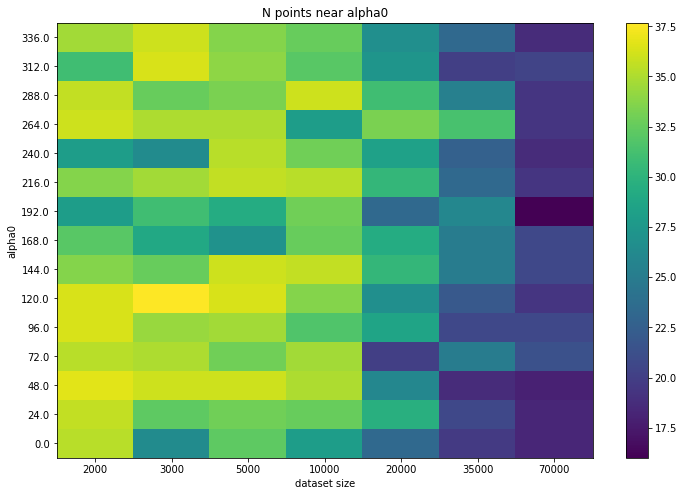

In [13]:
plt.figure(figsize=(12, 8))
plt.pcolor(vis_matrix.mean(axis=-1))
plt.colorbar()
plt.xticks([x+0.5 for x in range(len(data_size_to_idx))], sorted(data_size_to_idx.keys()))
plt.yticks([y+0.5 for y in range(len(angle_to_idx))], sorted(angle_to_idx.keys()))
plt.xlabel('dataset size')
plt.ylabel('alpha0')
plt.title('N points near alpha0')

Рассмотрим значение числа точек в окрестности, усредненное по всем углам:

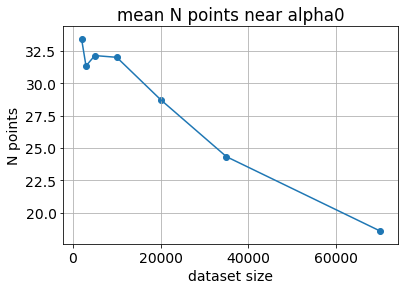

In [44]:
plt.plot(sorted(data_size_to_idx.keys()), vis_matrix.mean(axis=0))
plt.scatter(sorted(data_size_to_idx.keys()), vis_matrix.mean(axis=0))
plt.xlabel('dataset size')
plt.ylabel('N points')
plt.title('mean N points near alpha0')
plt.grid()

Получается, в среднем при увеличении размера доступных данных, число шагов до сходимости возрастает. Рассмотрим графики для размеров датасета $70000$ и $5000$.

*P.s. кто умеет возвращать figure из функции как объект, чтобы его можно было передать axes.show(), расскажите мне, как это делать :)*

/home/nexes/miniconda3/envs/tf_py3/lib/python3.6/site-packages/matplotlib/pyplot.py:528: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


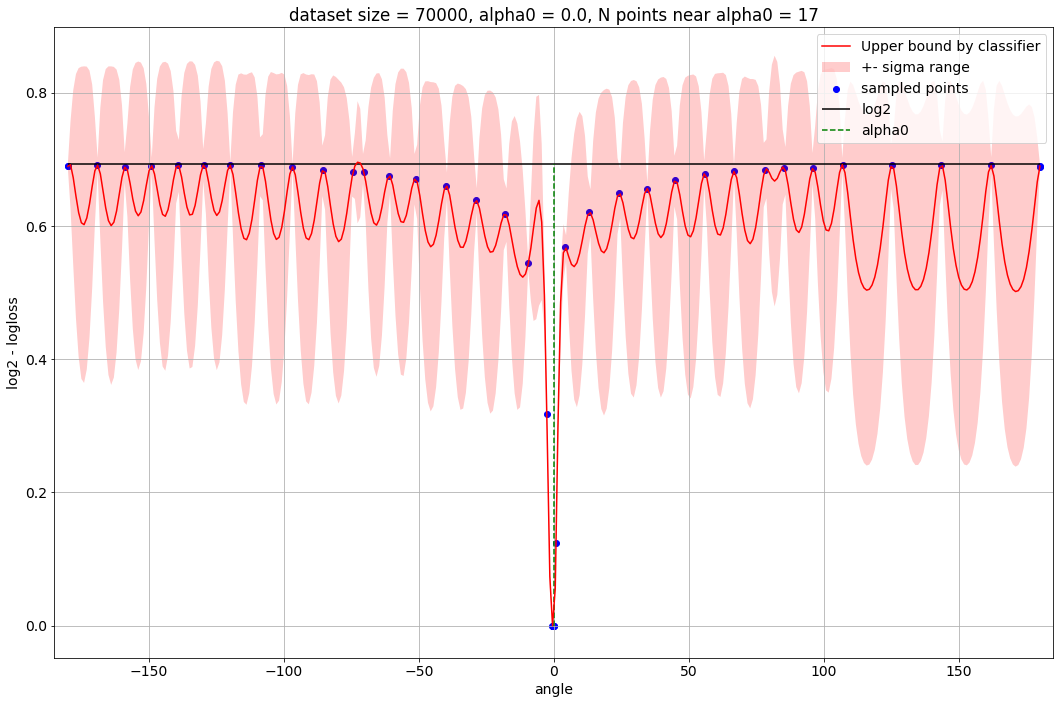

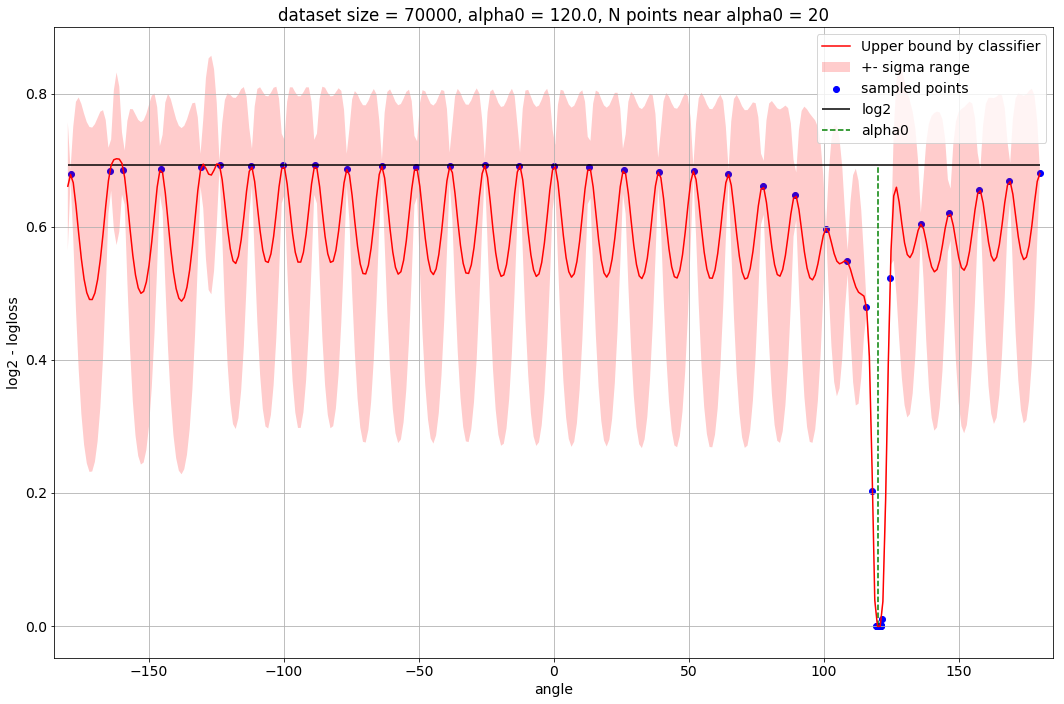

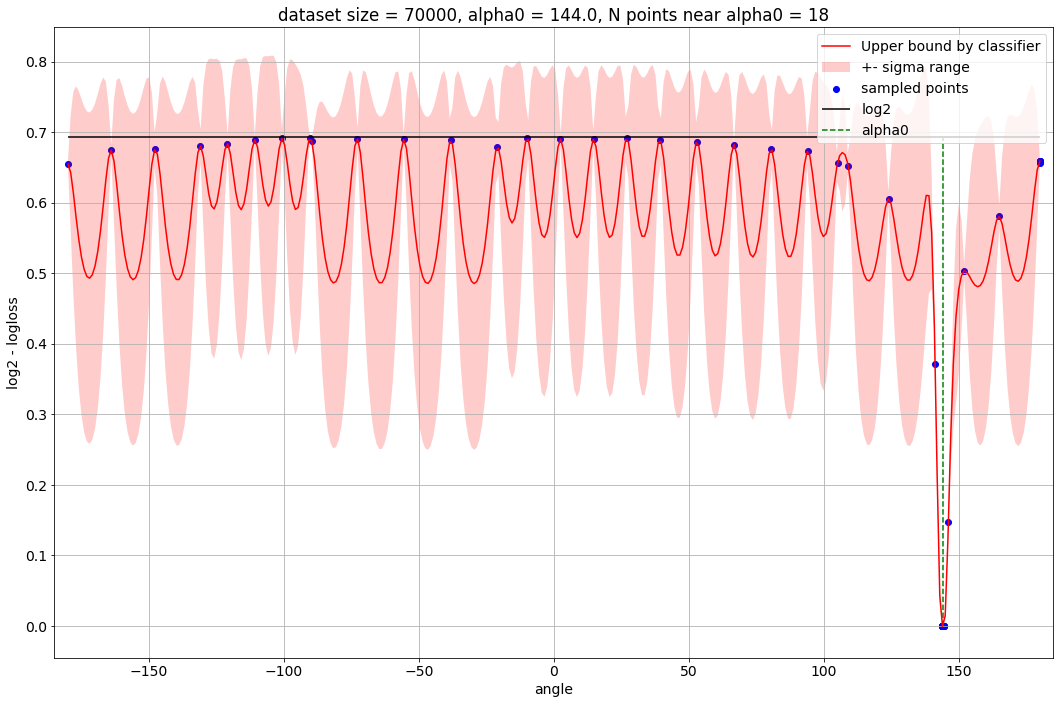

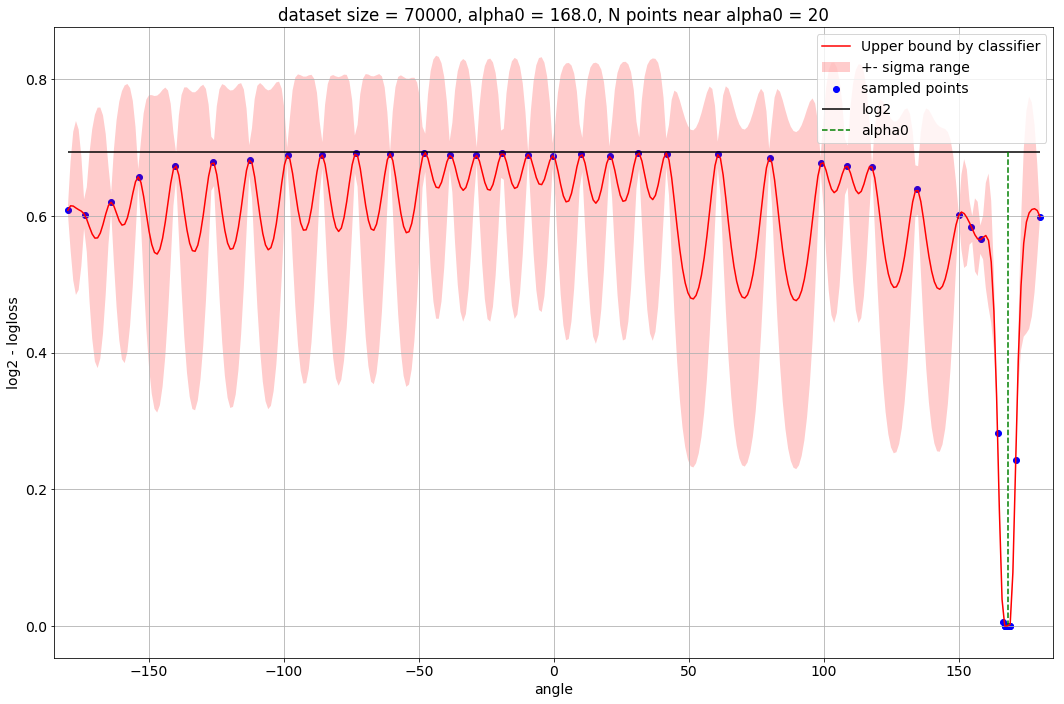

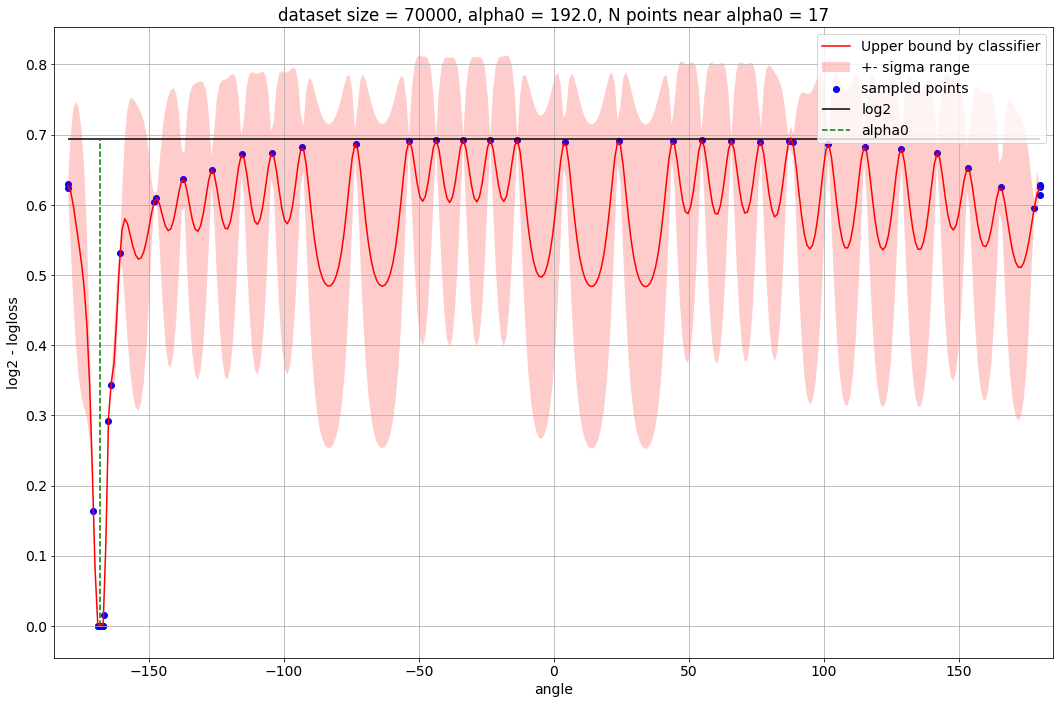

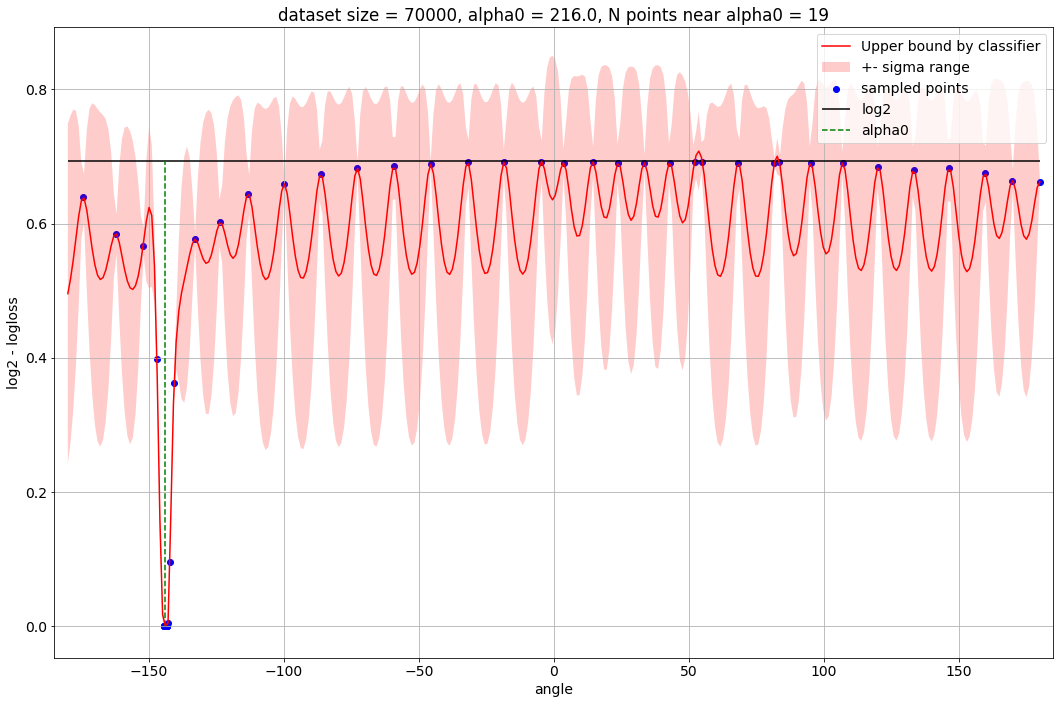

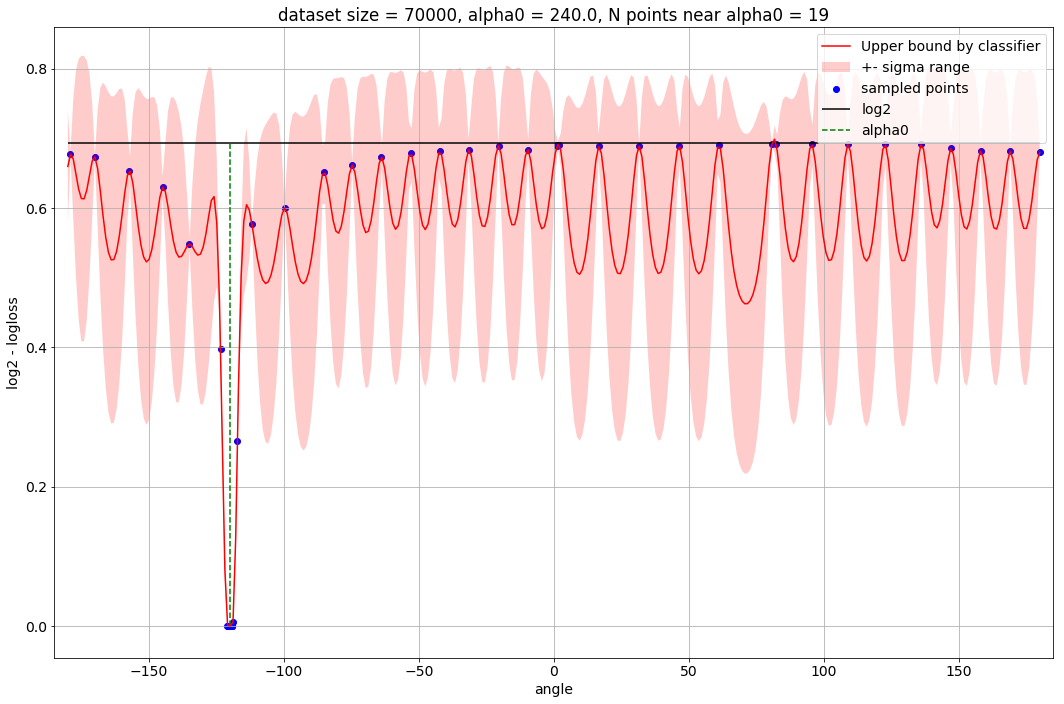

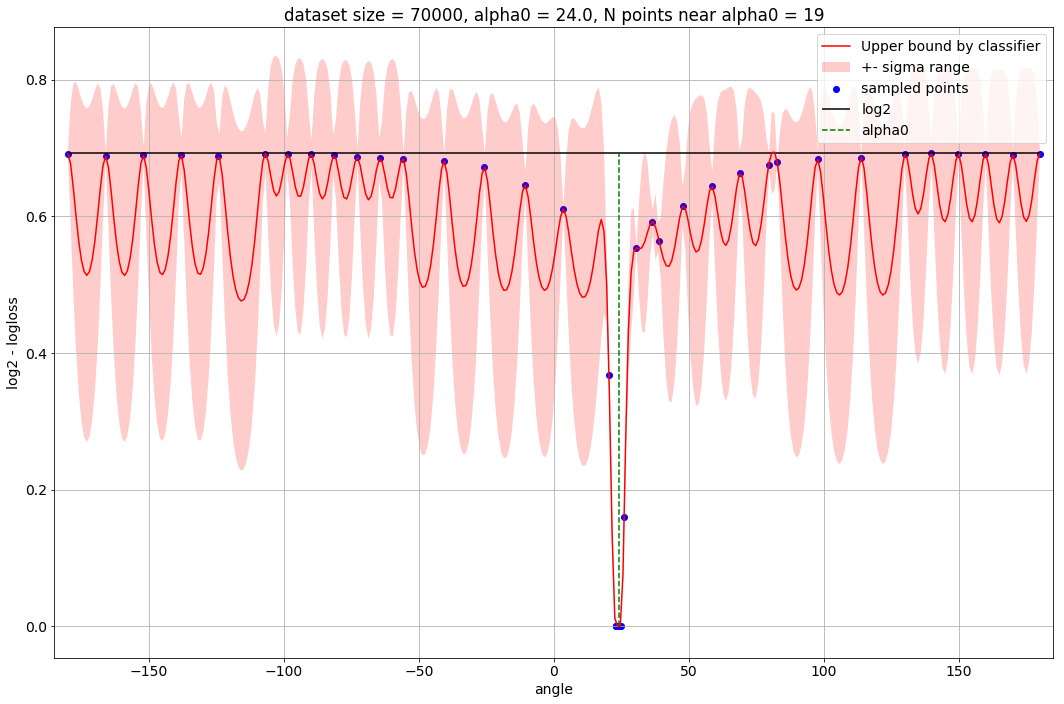

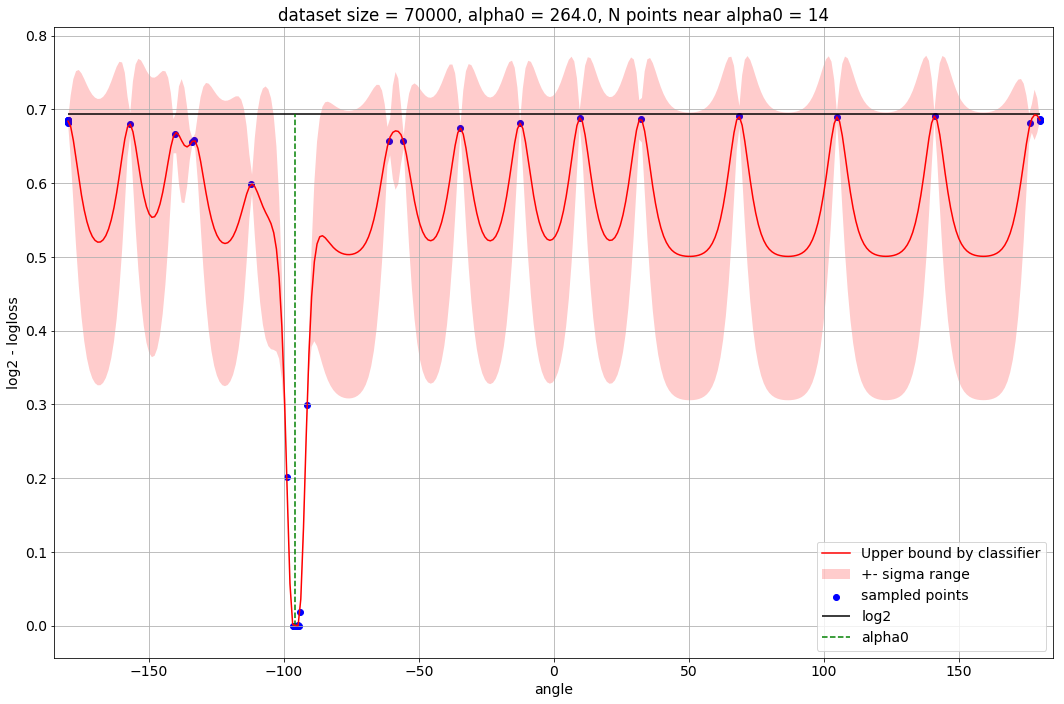

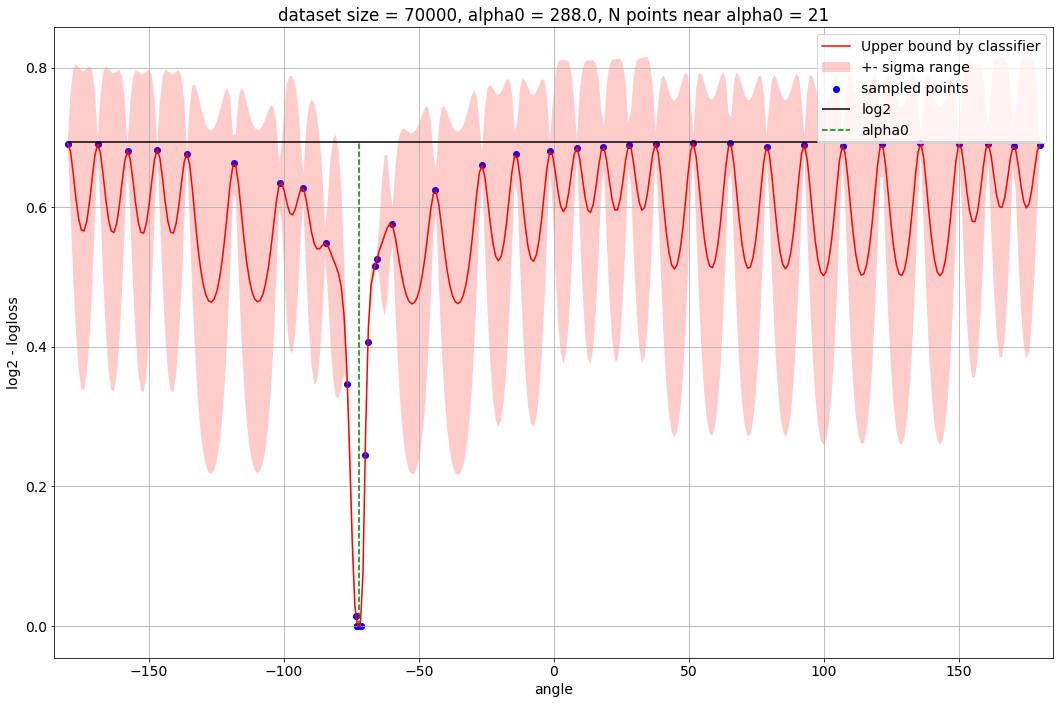

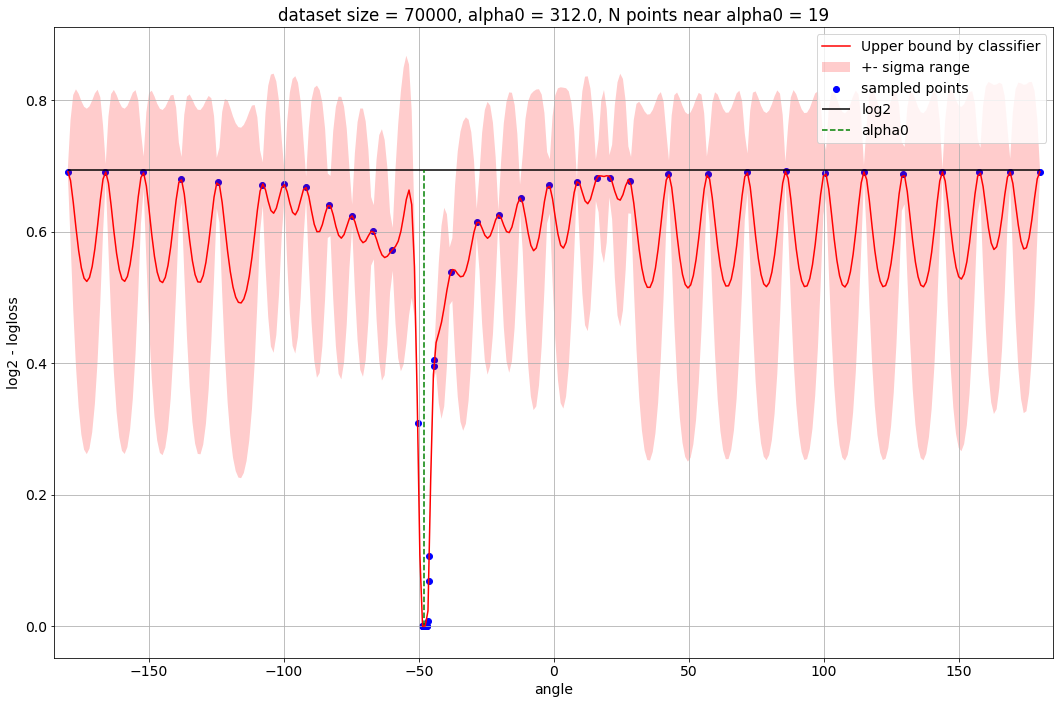

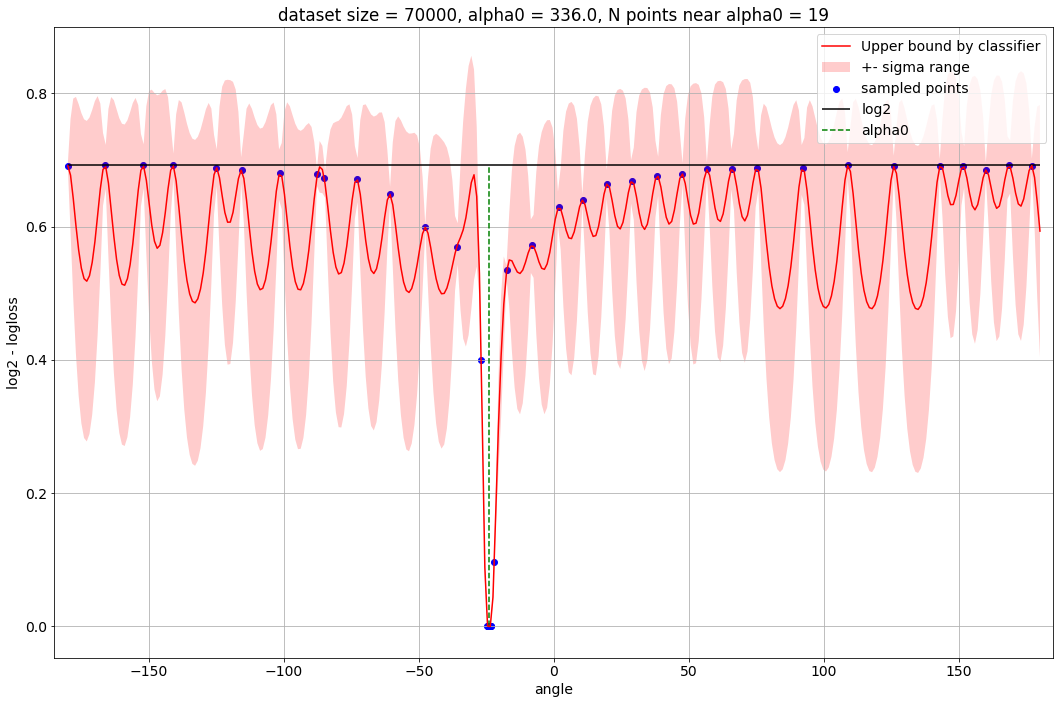

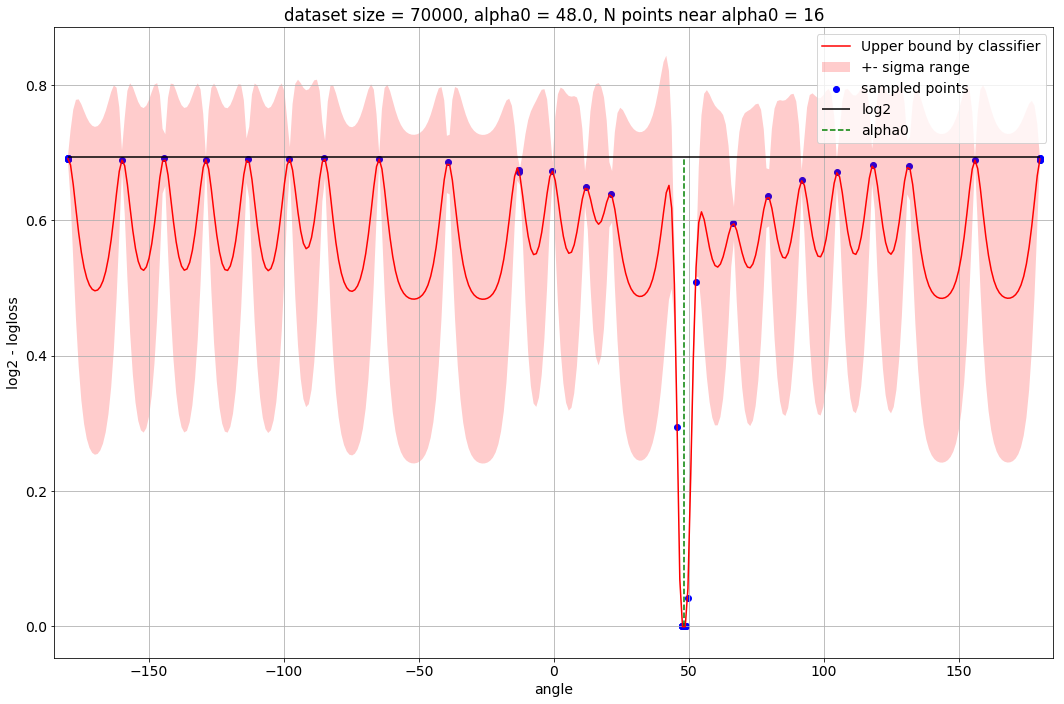

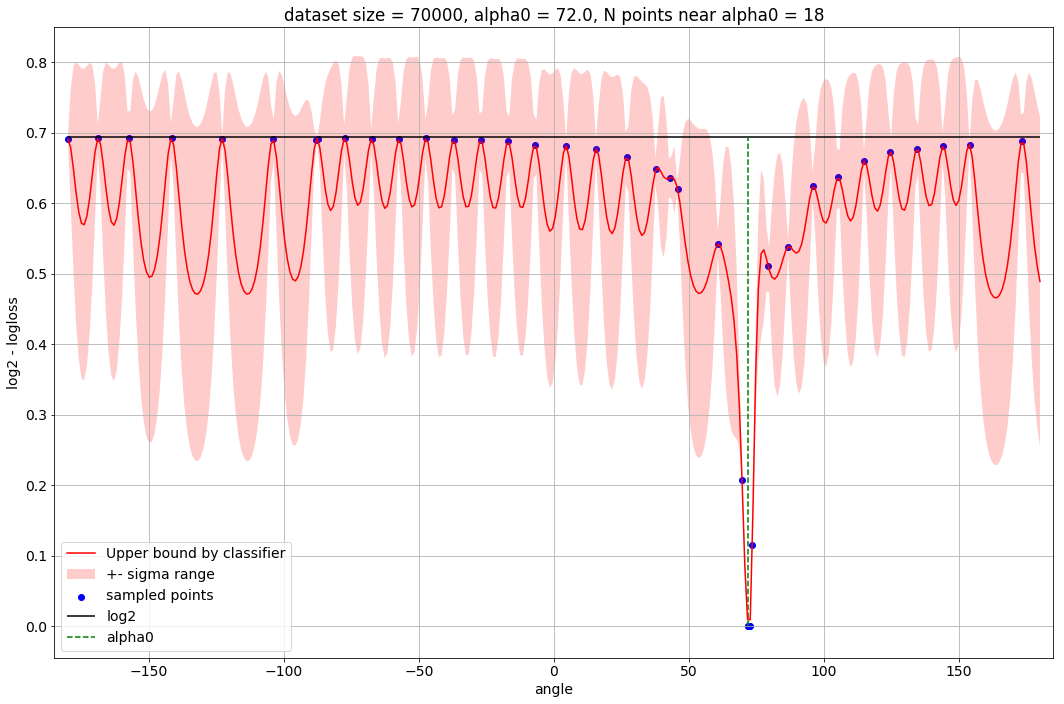

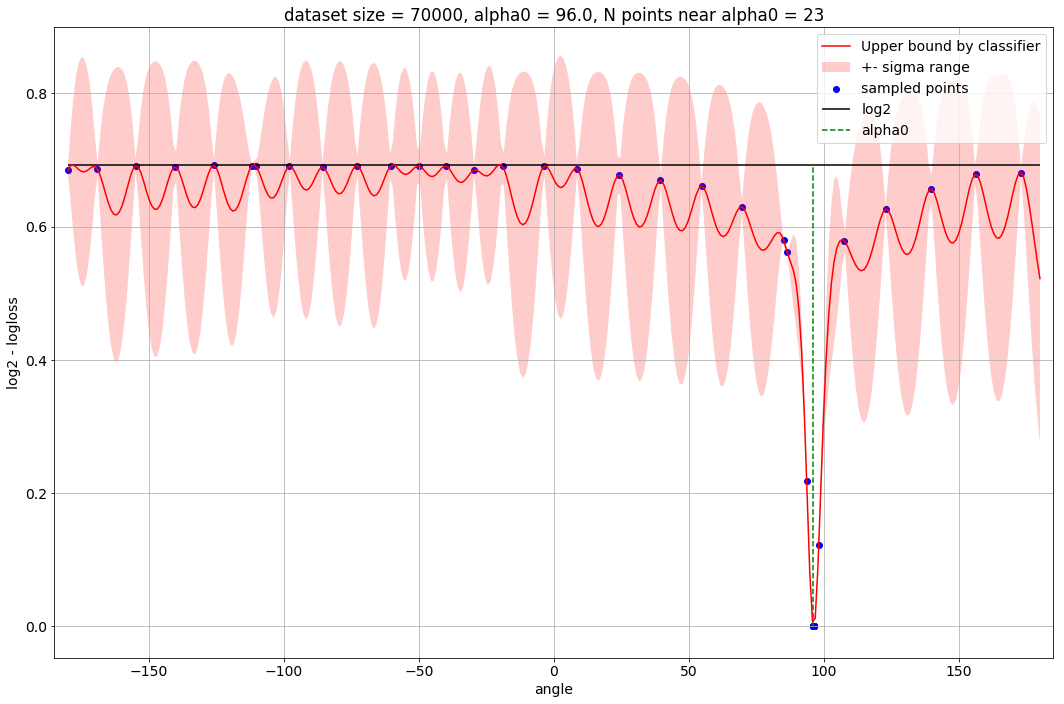

In [53]:
for key, val in results_dict.items():
    if key[1] == 70000:
        opt = val['opt']
        plt.figure(figsize=(12,8))
        _ = visualise(opt, alpha0=key[0], title='dataset size = {}, alpha0 = {}, N points near alpha0 = {}'.format(
            key[1], key[0], gen_N_points_near(opt, 10)))

/home/nexes/miniconda3/envs/tf_py3/lib/python3.6/site-packages/matplotlib/pyplot.py:528: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


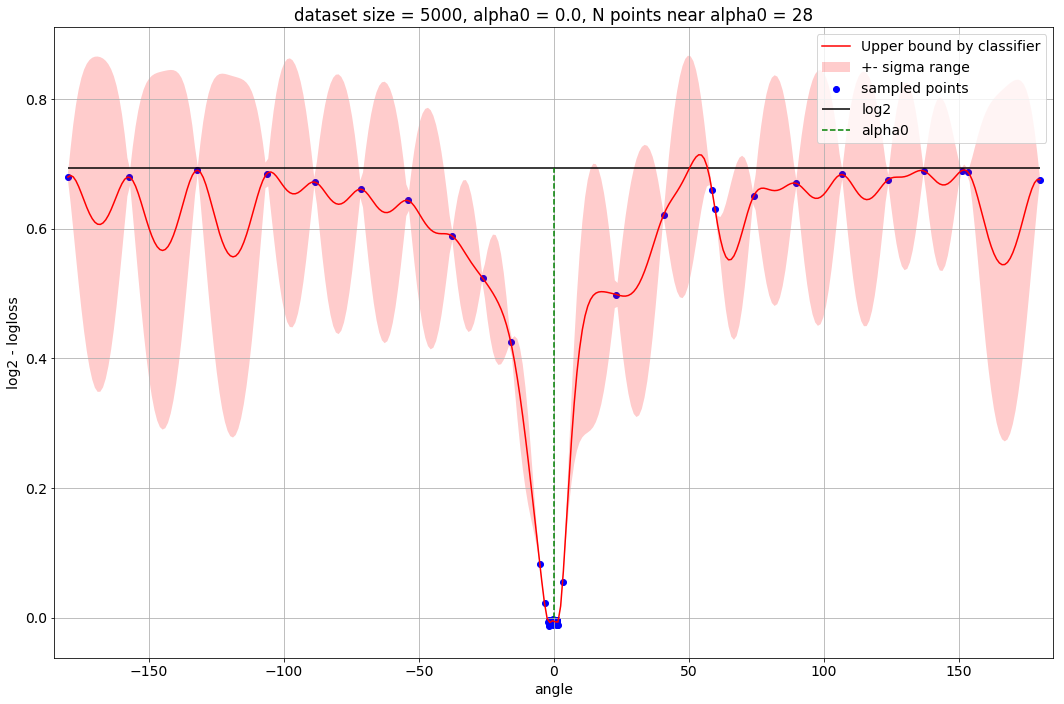

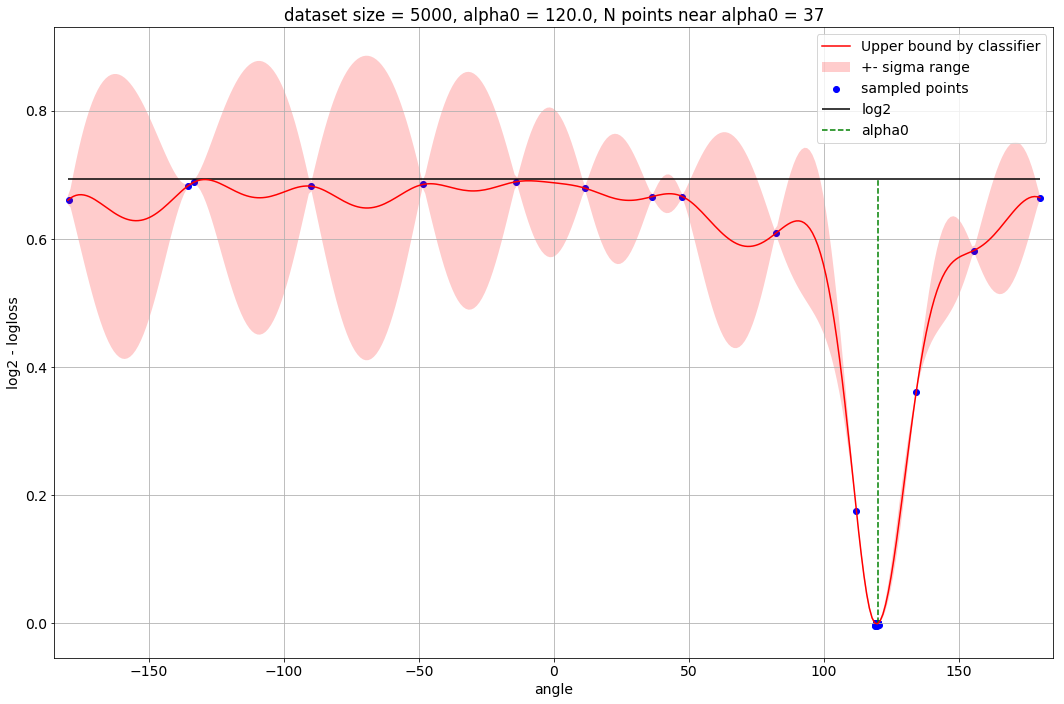

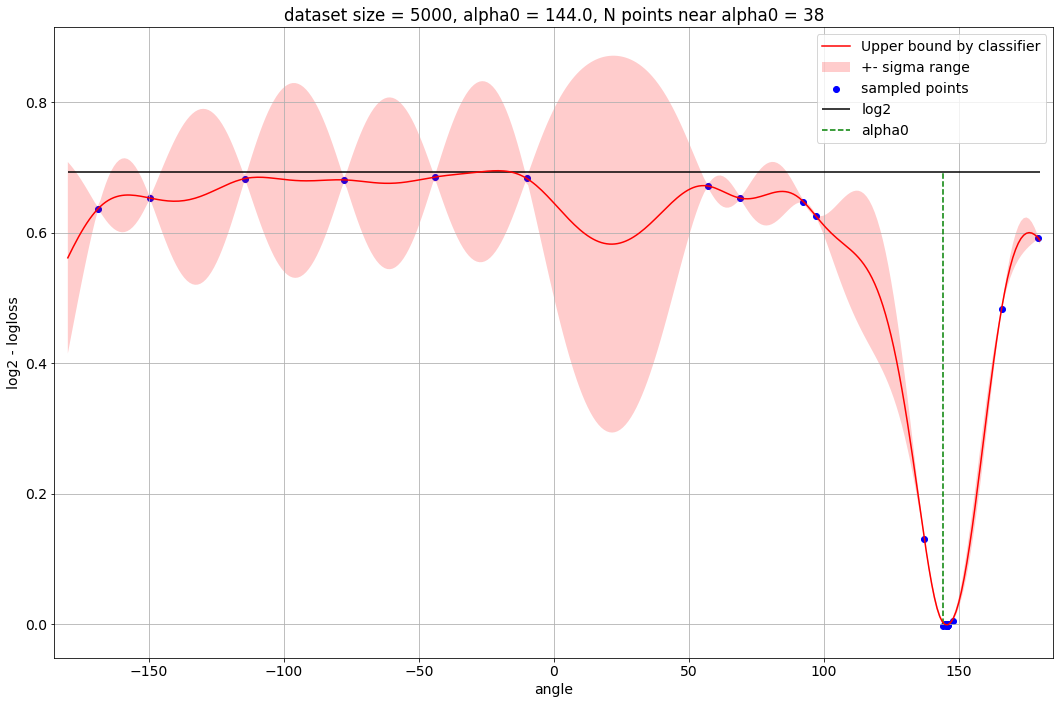

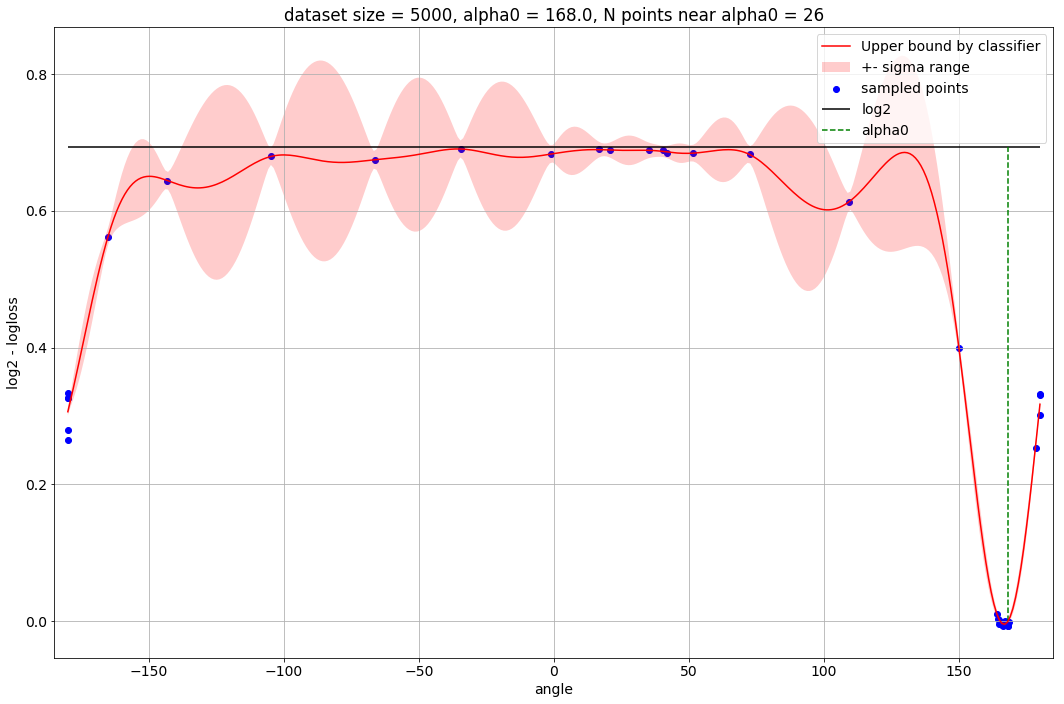

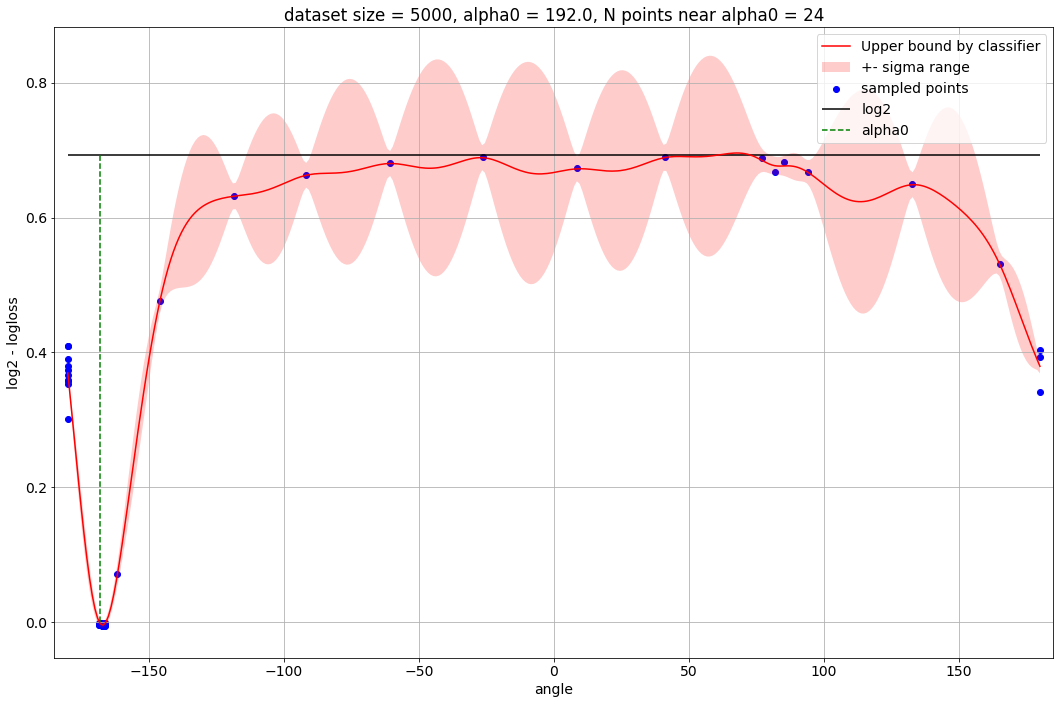

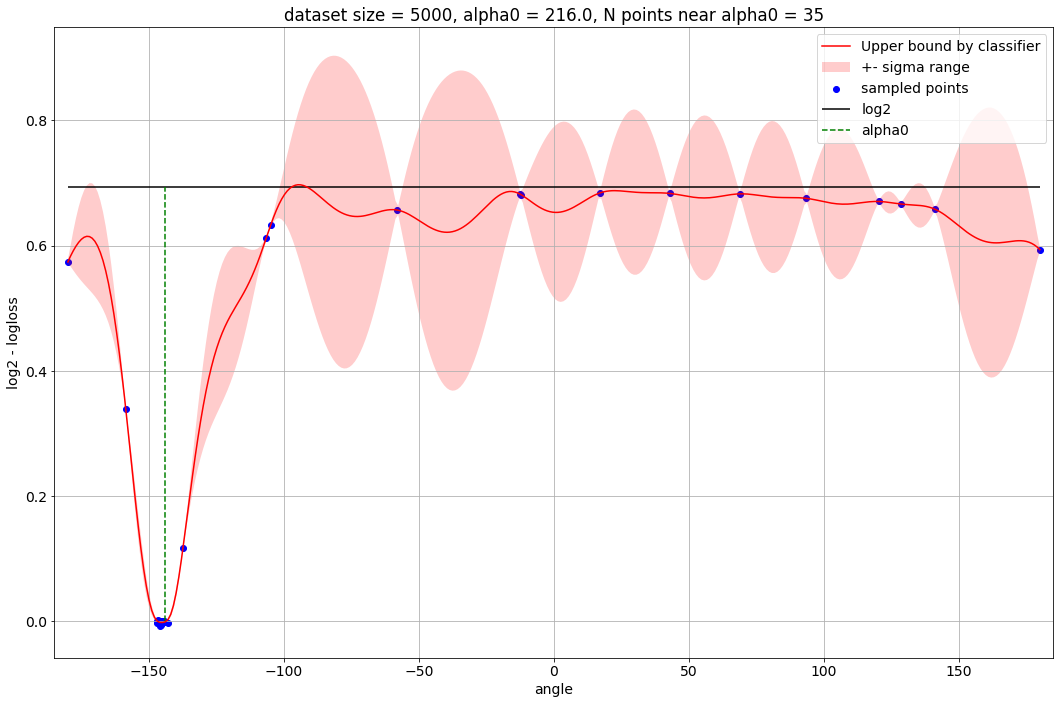

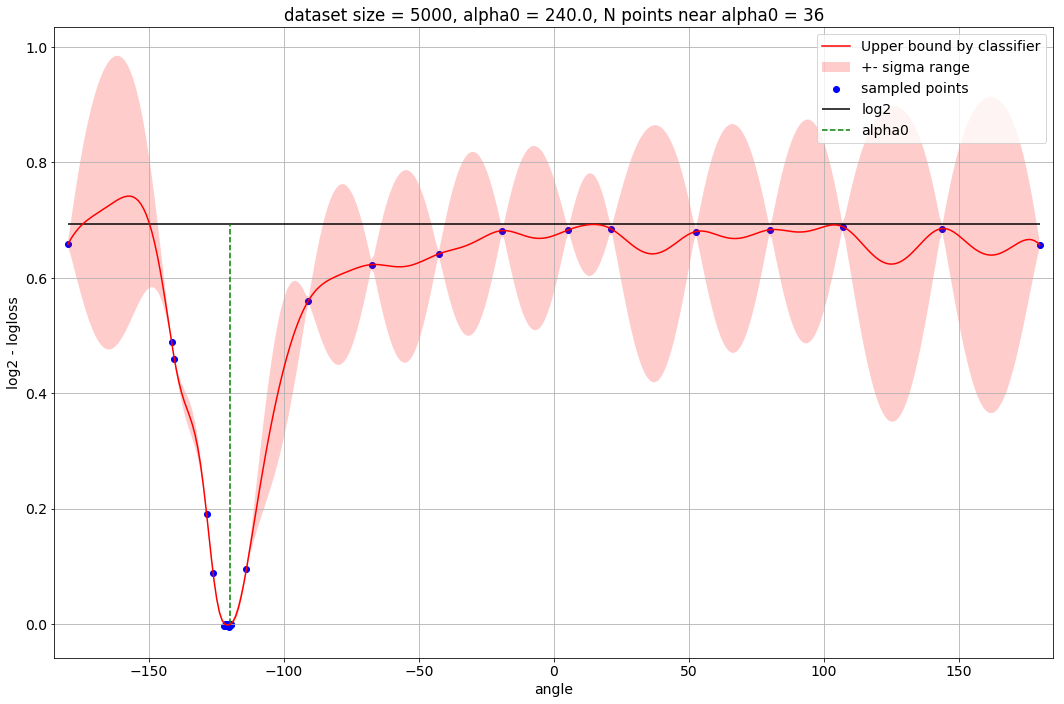

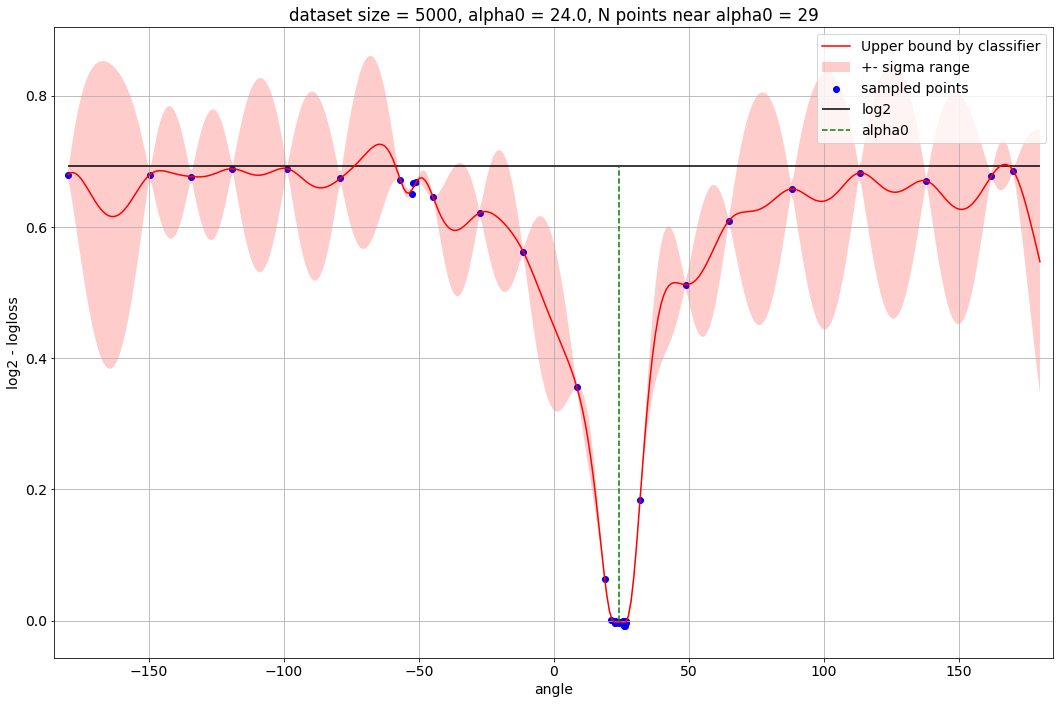

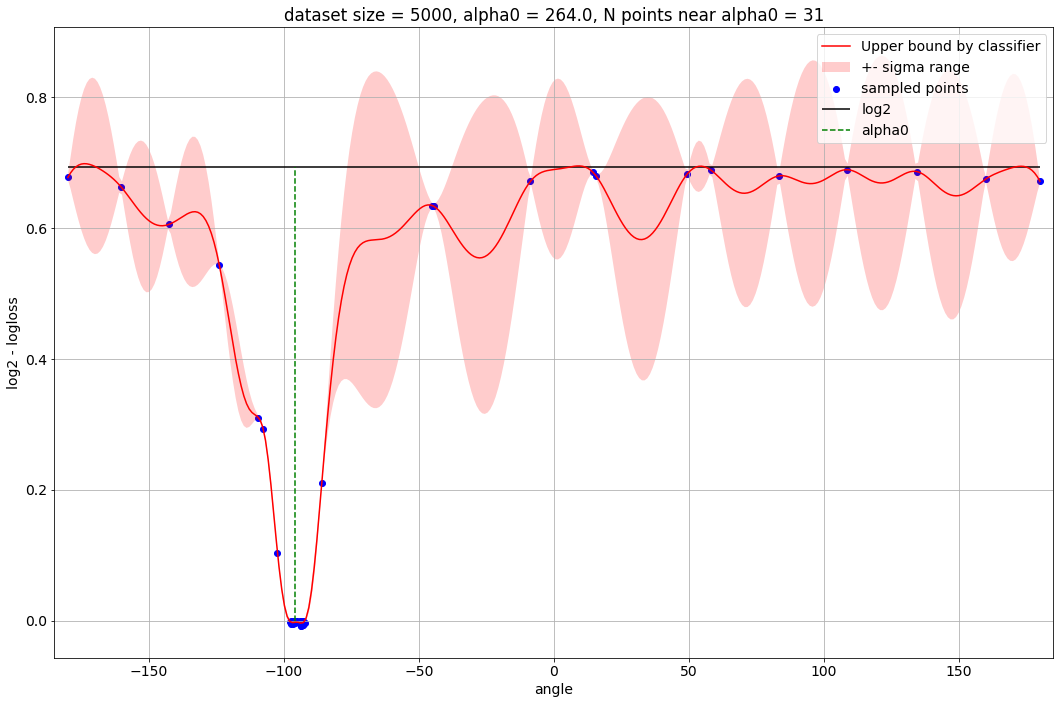

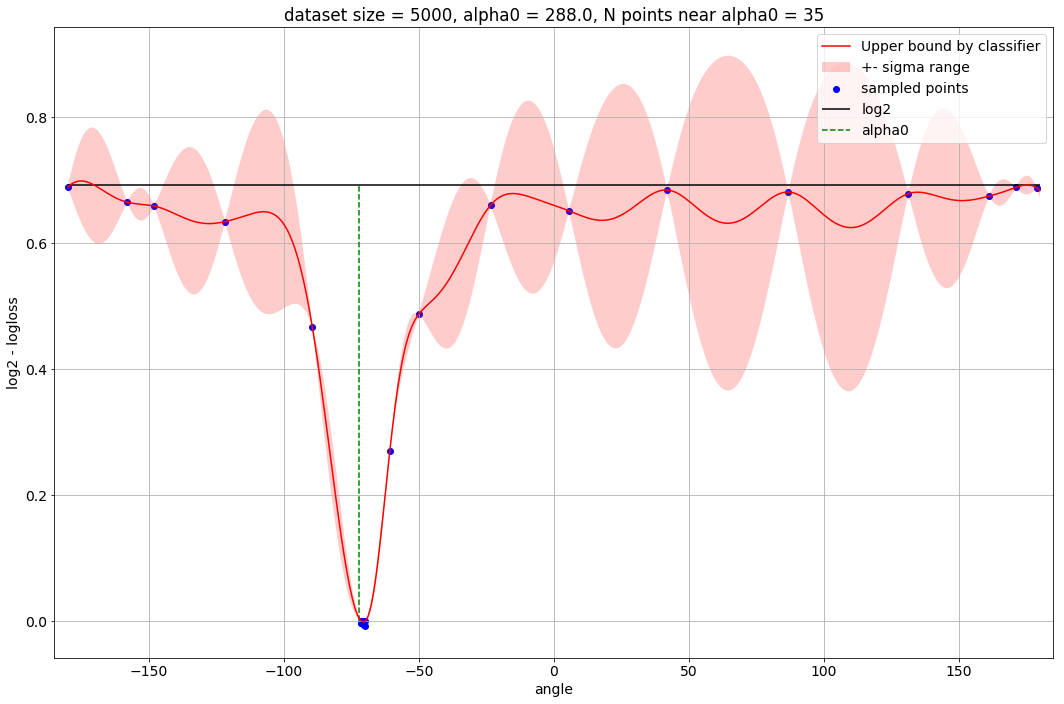

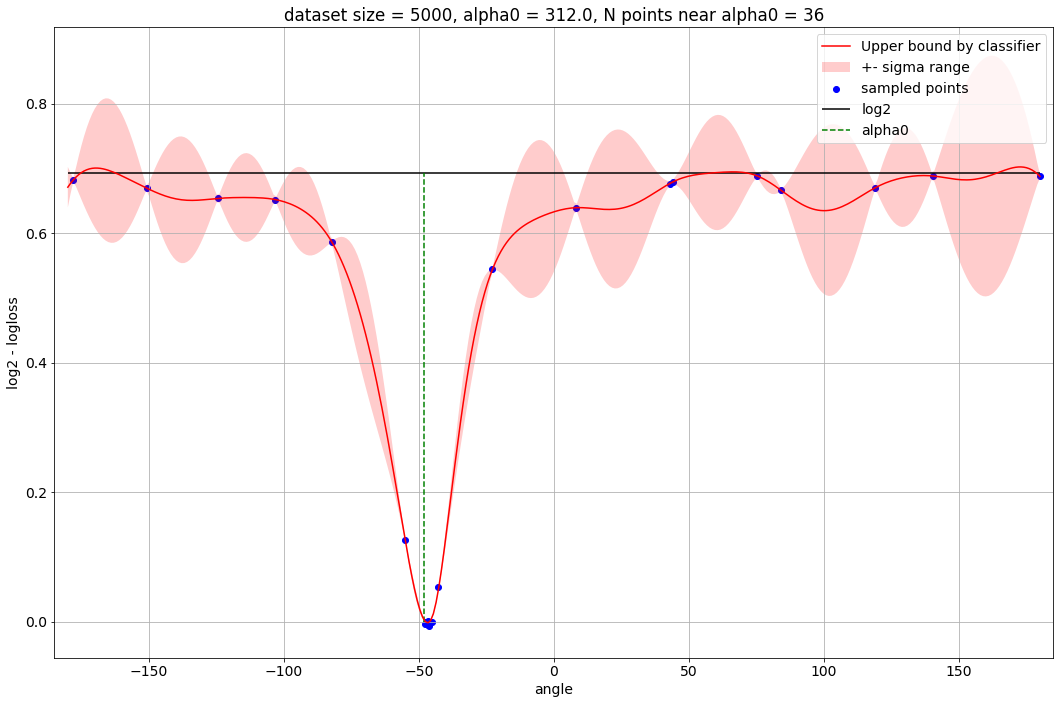

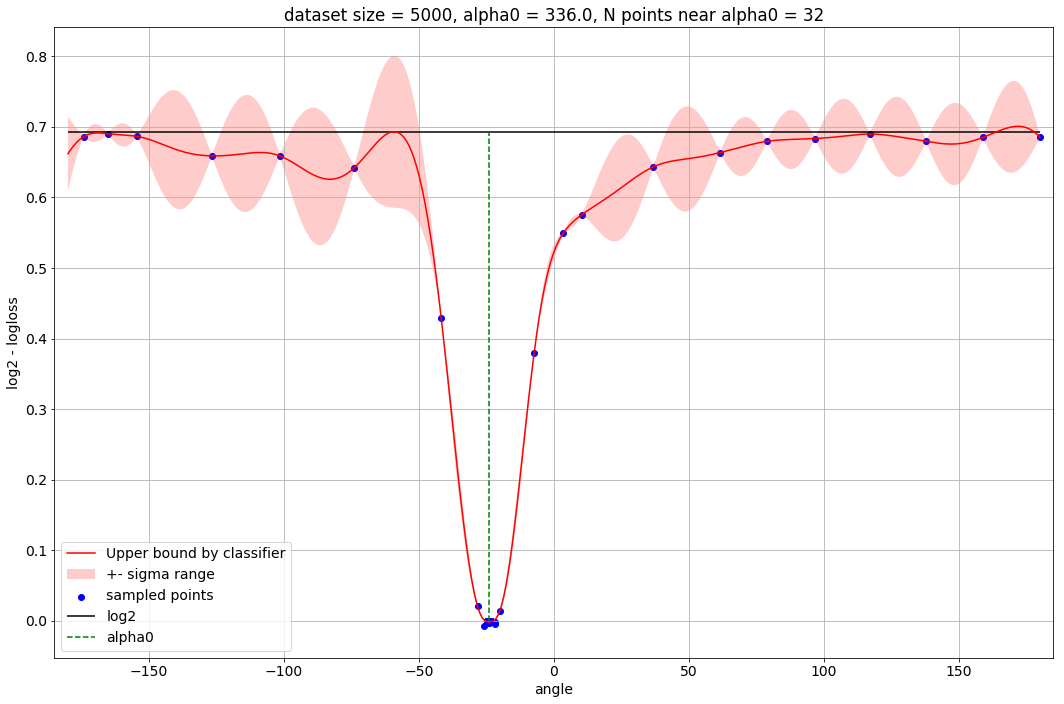

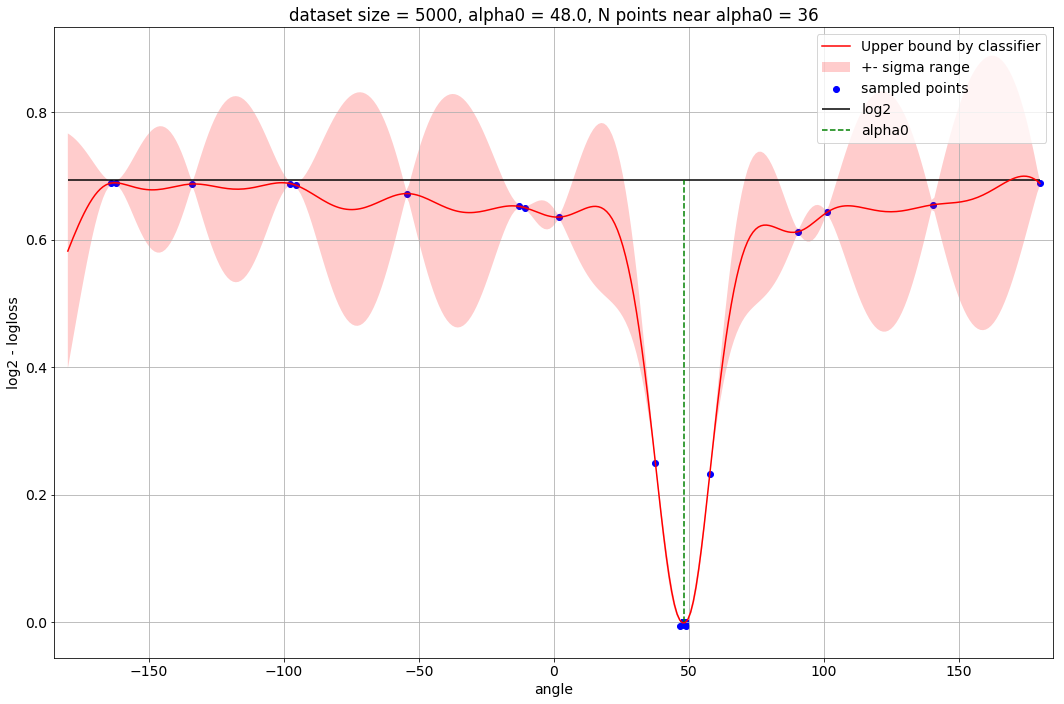

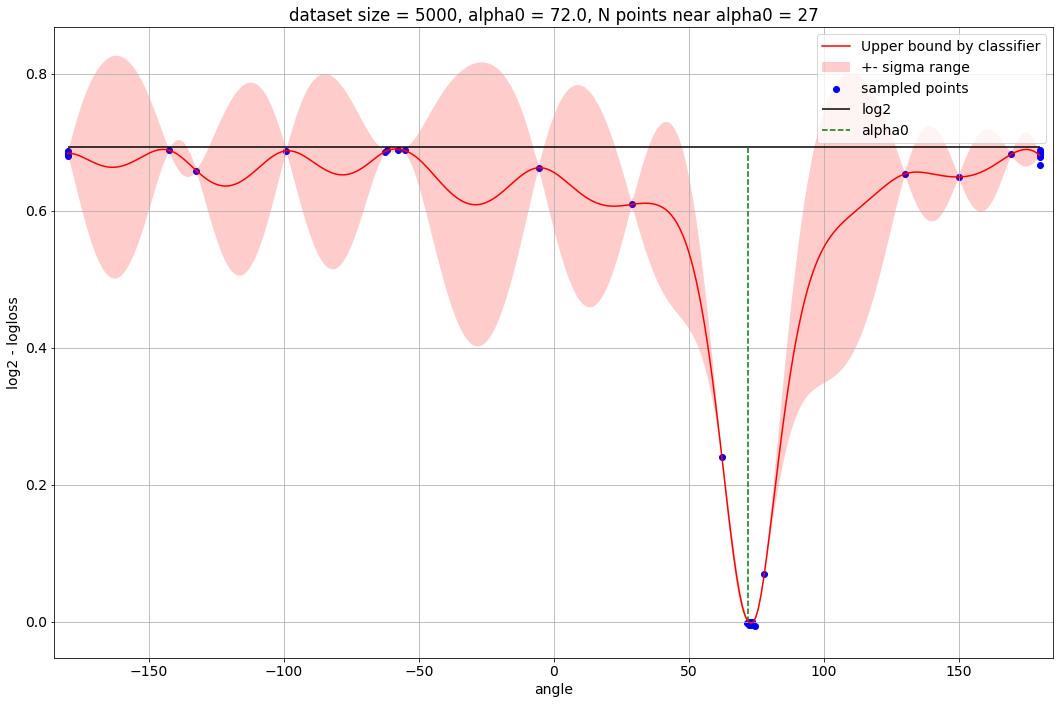

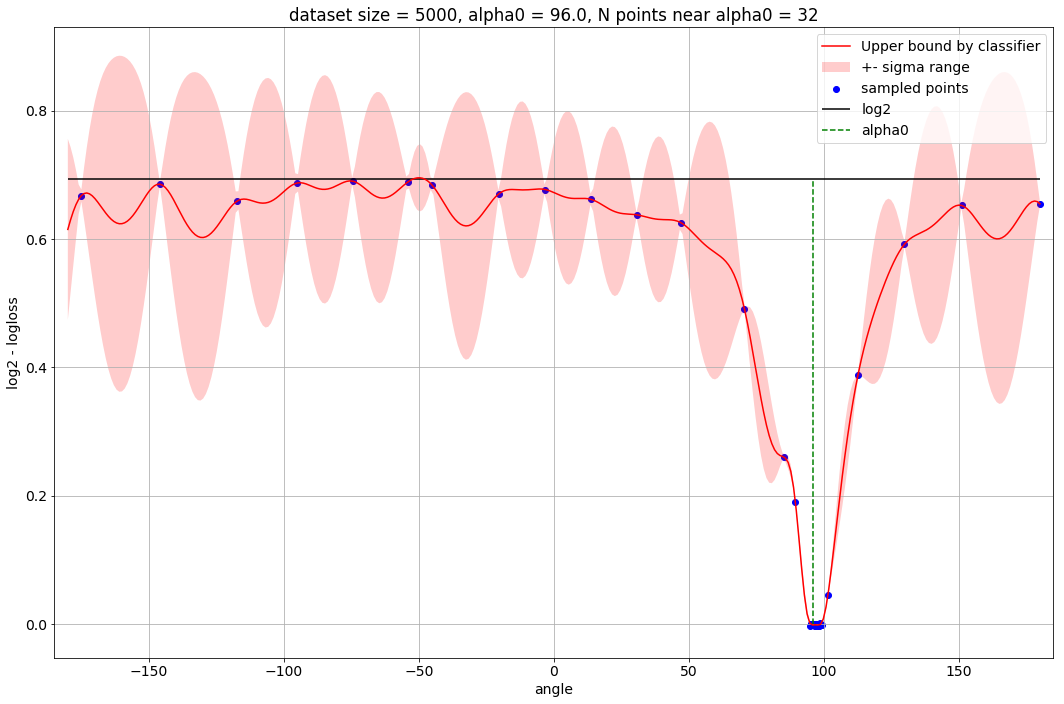

In [54]:
for key, val in results_dict.items():
    if key[1] == 5000:
        opt = val['opt']
        plt.figure(figsize=(12,8))
        _ = visualise(opt, alpha0=key[0], title='dataset size = {}, alpha0 = {}, N points near alpha0 = {}'.format(
            key[1], key[0], gen_N_points_near(opt, 10)))

Рассмотрим время, затраченное на семплирование в 50 точках (включая 10 случайных точек). Для каждого значения $\alpha$ датасет поворачивался на выбранный оптимизатором угол и происходило обучение сети (начальные веса случайны).

In [55]:
time_vis_matrix = np.zeros_like(vis_matrix)
for key, val in results_dict.items():
    time = val['time']
    time_vis_matrix[angle_to_idx[key[0]], 
                    data_size_to_idx[key[1]]] = time[2]-time[1] - int(val['raw_sysargv_params'][1])*(time[1]-time[0])

Text(0.5,1,'Time spent for optimization, s')

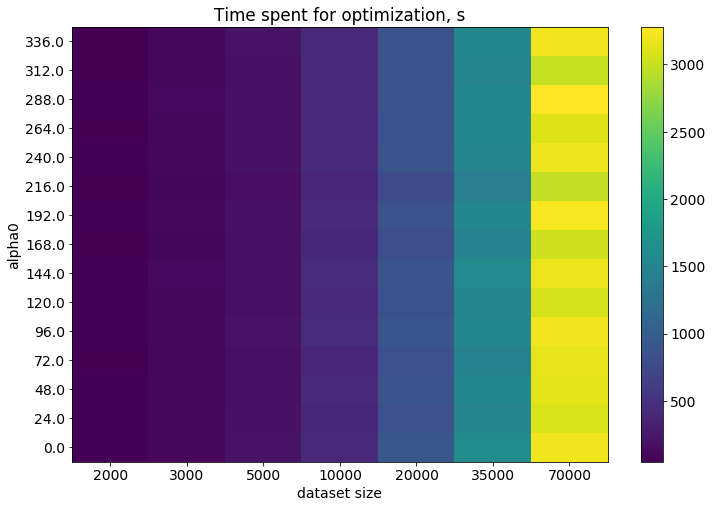

In [59]:
plt.figure(figsize=(12, 8))
plt.pcolor(time_vis_matrix)
plt.colorbar()
_ = plt.xticks([x+0.5 for x in range(len(data_size_to_idx))], sorted(data_size_to_idx.keys()))
_ = plt.yticks([y+0.5 for y in range(len(angle_to_idx))], sorted(angle_to_idx.keys()))
plt.xlabel('dataset size')
plt.ylabel('alpha0')
plt.title('Time spent for optimization, s')

Отнормируем на размер датасета чтобы не учитывать время, требующееся для поворота (+ обучение сети тоже зависит от количества доступных данных). 

In [60]:
time_vis_matrix = time_vis_matrix/np.array(sorted(data_size_to_idx.keys()))[None, :]

Text(0.5,1,'Time spent for optimization normed by dataset size, s/n_images')

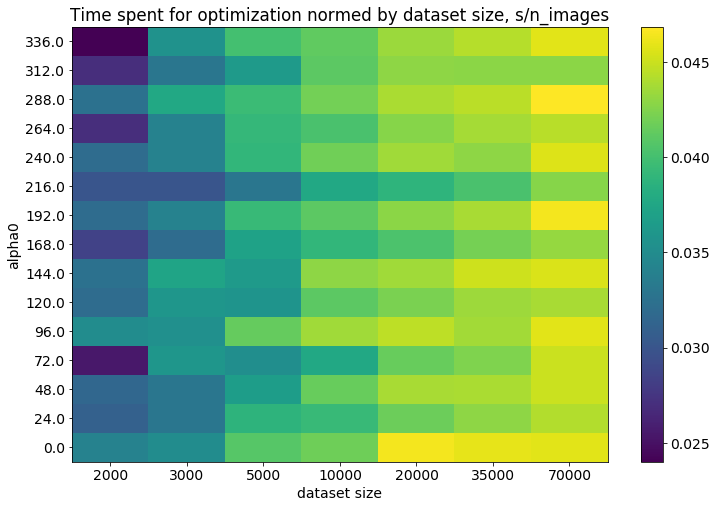

In [62]:
plt.figure(figsize=(12, 8))
plt.pcolor(time_vis_matrix)
plt.colorbar()
_ = plt.xticks([x+0.5 for x in range(len(data_size_to_idx))], sorted(data_size_to_idx.keys()))
_ = plt.yticks([y+0.5 for y in range(len(angle_to_idx))], sorted(angle_to_idx.keys()))
plt.xlabel('dataset size')
plt.ylabel('alpha0')
plt.title('Time spent for optimization normed by dataset size, s/n_images')

Видно, что время все еще растет. Рассмотрим графики:

/home/nexes/miniconda3/envs/tf_py3/lib/python3.6/site-packages/matplotlib/figure.py:418: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


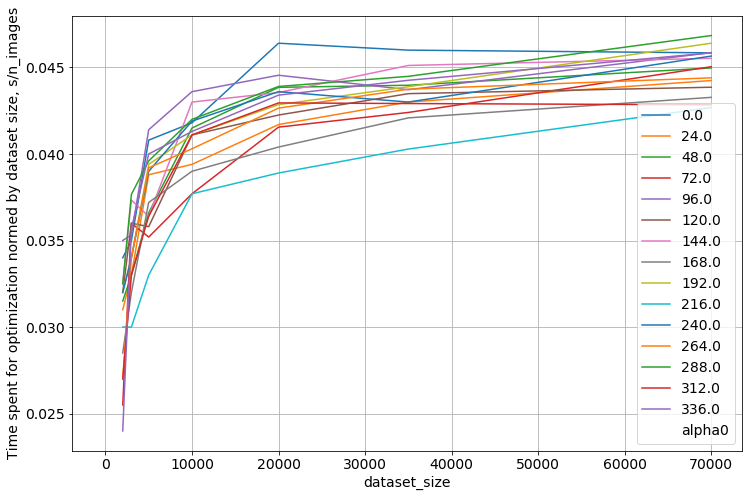

In [72]:
f = plt.figure(figsize=(12,8))
for idx, timeline in enumerate(time_vis_matrix):
    plt.plot(sorted(data_size_to_idx.keys()), timeline, label=sorted(angle_to_idx.keys())[idx])
plt.scatter([0], [0.035], alpha=0., label='alpha0')

plt.grid()
plt.xlabel("dataset_size")
plt.ylabel('Time spent for optimization normed by dataset size, s/n_images')
plt.legend()
f.show()

Вырисовывается логарифмическая зависимость, которая скрывается, скорее всего, в обучении сети.

Видим, что в среднем от значения $\alpha_0$ время обучения и число итераций до сходимости не зависят.

От размера обучающей выборки, напротив, они зависят. Для времени обучения это логично. Почему увеличение количества семплов повышает
количество шагов до сходимости - тема для размышления (по крайней мере, для меня.)

На этом пока все, можно легко добавить обучение сети из предыдущего состояния/регуляризацию на веса/более простую модель перед нейронкой.
В папке лежат файлы `master.py` и `start_optimization.py`, которые можно использовать для параллельных запусков на доступных нам мощностях.